In [15]:
from ray.rllib.offline.json_reader import JsonReader
import numpy as np
import tensorflow as tf
from tqdm import trange, tqdm
import matplotlib.pyplot as plt

In [16]:
input_reader = JsonReader("logs/APPO/RE3")

2022-12-19 15:42:33,884	WARNING json_reader.py:146 -- Treating input directory as glob patterns: ['/tf/Cage/Notebooks/logs/APPO/RE3/*.json', '/tf/Cage/Notebooks/logs/APPO/RE3/*.zip']


In [17]:
sequence_length=3
num_episodes = 2000
windows_per_episode = 100-sequence_length
state_len = 52
num_action = 1
encoding_len = state_len + num_action

data_points = num_episodes * windows_per_episode

X = np.zeros((data_points,sequence_length,encoding_len))
Y = np.zeros((data_points,state_len))

index = 0
for e in trange(num_episodes):
    data = input_reader.next()
    for i in range(0, windows_per_episode):
        r = data['reward'][i]
        if i < sequence_length:
            s = np.zeros((sequence_length, encoding_len))
            for k in range(0,i):
                s[k,:] = np.concatenate([data['obs'][k], np.zeros(num_action)])
        else:
            #vec = np.zeros((sequence_length, num_action))
            #vec[np.arange(sequence_length),data['actions'][i-sequence_length:i]] = 1
            vec = np.array(data['actions'][i-sequence_length:i]) / 145
            vec = vec.reshape(sequence_length,1)
            s = np.concatenate([data['obs'][i-sequence_length:i], vec], axis=1)
            
        X[index,:,:] = s
        Y[index,:] = ns
        index += 1

100%|██████████| 2000/2000 [00:31<00:00, 63.47it/s]


In [18]:
new_state = {}
for i, matrix in enumerate(tqdm(X)):
    if (X[10]==matrix).all():
        if not Y[i,:].tobytes() in new_state:
            new_state[Y[i,:].tobytes()] = 1
        else:
            new_state[Y[i,:].tobytes()] += 1
            
ns = {k: v for k, v in sorted(new_state.items(), key=lambda item: item[1], reverse=True)}
            
for s in new_state.keys():
    print(new_state[s])
    print(np.frombuffer(s))

print(len(new_state.keys()))

100%|██████████| 198000/198000 [00:01<00:00, 153958.45it/s]


5
[0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
41
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
7
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1.]
4
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 1.]
6
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1.]
13
[0. 0. 0. 0. 1. 0. 0. 0.

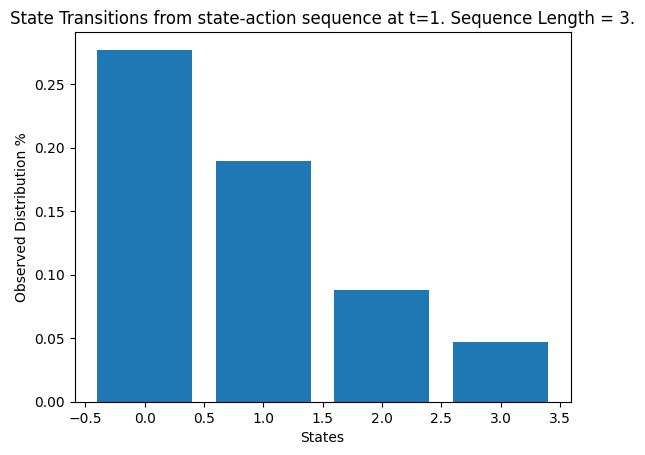

In [19]:
ns = {k: v for k, v in sorted(new_state.items(), key=lambda item: item[1], reverse=True)}

values = []
for s in ns.keys():
    values.append(ns[s])
y_pos = np.arange(4)

values = np.array(values) / sum(values)

# Create bars
plt.title('State Transitions from state-action sequence at t=1. Sequence Length = 3.')
plt.xlabel('States')
plt.ylabel('Observed Distribution %')
plt.bar(y_pos, values[:4])
plt.show()

In [80]:
values

array([1.])

In [20]:
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import Bidirectional


model = Sequential()
model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True), input_shape=(sequence_length, encoding_len)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(state_len, activation='sigmoid'))
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.Accuracy()])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

print(model.summary())

model.fit(X[:int(2e5)], Y[:int(2e5)], epochs=250, validation_split=0.1, verbose=1, callbacks=[callback], batch_size=256)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 512)           634880    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (No

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


178200/178200 [==============================] - 5s 26us/sample - loss: 0.0371 - accuracy: 3.0260e-04 - val_loss: 0.0254 - val_accuracy: 0.0000e+00
Epoch 2/250
178200/178200 [==============================] - 3s 20us/sample - loss: 0.0244 - accuracy: 0.0000e+00 - val_loss: 0.0235 - val_accuracy: 0.0000e+00
Epoch 3/250
178200/178200 [==============================] - 4s 20us/sample - loss: 0.0233 - accuracy: 0.0000e+00 - val_loss: 0.0237 - val_accuracy: 0.0000e+00
Epoch 4/250
178200/178200 [==============================] - 4s 20us/sample - loss: 0.0231 - accuracy: 0.0000e+00 - val_loss: 0.0234 - val_accuracy: 0.0000e+00
Epoch 5/250
178200/178200 [==============================] - 4s 20us/sample - loss: 0.0229 - accuracy: 0.0000e+00 - val_loss: 0.0231 - val_accuracy: 0.0000e+00
Epoch 6/250
178200/178200 [==============================] - 4s 20us/sample - loss: 0.0228 - accuracy: 0.0000e+00 - val_loss: 0.0232 - val_accuracy: 0.0000e+00
Epoch 7/250
178200/178200 [=========================

178200/178200 [==============================] - 4s 20us/sample - loss: 0.0211 - accuracy: 2.1529e-04 - val_loss: 0.0234 - val_accuracy: 7.6729e-05
Epoch 53/250
178200/178200 [==============================] - 3s 20us/sample - loss: 0.0211 - accuracy: 2.2490e-04 - val_loss: 0.0235 - val_accuracy: 6.6045e-05
Epoch 54/250
178200/178200 [==============================] - 4s 20us/sample - loss: 0.0211 - accuracy: 2.2328e-04 - val_loss: 0.0234 - val_accuracy: 8.0614e-05
Epoch 55/250
178200/178200 [==============================] - 4s 20us/sample - loss: 0.0211 - accuracy: 2.4486e-04 - val_loss: 0.0234 - val_accuracy: 6.5074e-05
Epoch 56/250
178200/178200 [==============================] - 4s 20us/sample - loss: 0.0210 - accuracy: 2.6267e-04 - val_loss: 0.0234 - val_accuracy: 1.1072e-04
Epoch 57/250
178200/178200 [==============================] - 4s 20us/sample - loss: 0.0210 - accuracy: 2.7853e-04 - val_loss: 0.0235 - val_accuracy: 1.0101e-04
Epoch 58/250
178200/178200 [===================

In [21]:
predictions = np.round(model.predict(X[0:10000]))
count = 0
for i in range(10000):
    if (predictions[i]==Y[i]).all():
        count += 1
count

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


3309

In [47]:
print(np.round(model.predict(np.array([X[1]])))[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [48]:
print(Y[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [95]:
p = model.predict(np.array([X[1]]))[0]
p[np.where(Y[0]==1)]

array([0.02952596], dtype=float32)

In [110]:
new_state = {}
for i, matrix in enumerate(tqdm(X)):
    if (X[3]==matrix).all():
        if not Y[i,:].tobytes() in new_state:
            new_state[Y[i,:].tobytes()] = 1
        else:
            new_state[Y[i,:].tobytes()] += 1
            
ns = {k: v for k, v in sorted(new_state.items(), key=lambda item: item[1], reverse=True)}

count = 0
for s in ns.keys():
    count += new_state[s]
    print(new_state[s])
    print(np.frombuffer(s))

print(len(new_state.keys()))
count

 21%|██        | 2054464/9700000 [00:13<00:51, 148353.44it/s]


KeyboardInterrupt: 

In [111]:
prediction = model.predict(np.array([X[3]]))[0]

new_state = {}

for i in range(2511):
    state = np.zeros(52)
    for i in range(52):
        state[i] = np.array(np.random.rand() < prediction[i], dtype=np.int8)
    if not state.tobytes() in new_state:
        new_state[state.tobytes()] = 1
    else:
        new_state[state.tobytes()] += 1
        
ns = {k: v for k, v in sorted(new_state.items(), key=lambda item: item[1], reverse=True)}
            
for s in ns.keys():
    print(ns[s])
    print(np.frombuffer(s))

print(len(new_state.keys()))

2240
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0.]
179
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0.]
63
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0.]
23
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
4
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0.]
2
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
6


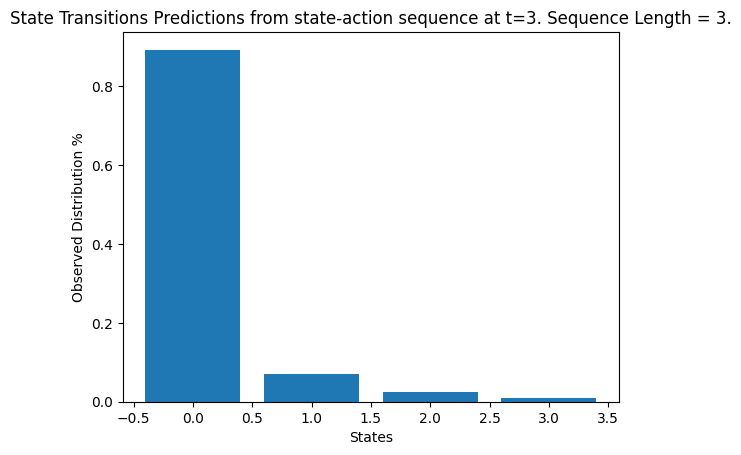

In [113]:


values = []
for s in ns.keys():
    values.append(ns[s])
y_pos = np.arange(4)

values = np.array(values) / sum(values)

# Create bars
plt.title('State Transitions Predictions from state-action sequence at t=3. Sequence Length = 3.')
plt.xlabel('States')
plt.ylabel('Observed Distribution %')
plt.bar(y_pos, values[:4])
plt.show()

In [109]:
prediction

array([1.03190523e-02, 3.29323782e-04, 3.85479216e-04, 4.18740936e-04,
       2.88093448e-01, 3.55923170e-04, 1.17589640e-04, 3.77577089e-04,
       1.46027789e-01, 1.21319026e-03, 5.94214769e-03, 3.11347633e-03,
       1.58526480e-01, 5.01110917e-03, 8.59338616e-04, 1.89331674e-03,
       1.07140923e-02, 3.76689044e-04, 4.23285324e-04, 4.73172520e-04,
       2.87872516e-02, 4.47978149e-04, 3.78162280e-04, 4.29429463e-04,
       1.22959904e-01, 4.14958806e-04, 4.10935085e-04, 3.16793390e-04,
       2.65722424e-02, 8.66414886e-03, 4.03991144e-04, 3.33420746e-02,
       9.18903127e-02, 2.98331375e-04, 4.02375124e-04, 4.05244122e-04,
       2.98894614e-01, 1.67272076e-01, 1.90242694e-03, 1.67976305e-01,
       3.59961241e-01, 2.58691251e-01, 3.61492159e-04, 2.48664573e-01,
       1.34916067e-01, 4.06041630e-02, 4.45044658e-04, 4.43339422e-02,
       3.97519410e-01, 3.22330505e-01, 1.07264658e-02, 3.51259202e-01],
      dtype=float32)

In [12]:
for i, matrix in enumerate(X):
    if (X[10]==matrix).all():
        if not Y[i].tobytes() in new_state:
            new_state[Y.tobytes()] = 1
        else:
            new_state[Y.tobytes()] += 1
            
for s in new_state.keys():
    print(new_state[s])
    print(np.frombuffer(s))

print(len(new_state.keys()))

1
[0. 0. 0. ... 0. 0. 0.]
1


In [ ]:
np.save('target.npy',X[10])
np.save('prediction.npy',p)